# Customer Segment Analysis_RFM
Dataset from dacon 

* R(Recency)
* F(Frequency)
* M(Monetary)

Segment
VIP (0.1%)
Loyal (1.7%)
Potential Loyal (14.7%)
Must-Not-Lose (2.9%)
Recent New (30.7%)
At-Risk (16.8%)
Others

**Table of contents**
1. Data Preprocessing
1. Data Analysis & Visualizations
1. Modeling

In [1]:
# import library
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data load
customer = pd.read_csv('/kaggle/input/customer-segment/Customer_info.csv')
discount = pd.read_csv('/kaggle/input/customer-segment/Discount_info.csv')
marketing = pd.read_csv('/kaggle/input/customer-segment/Marketing_info.csv')
onlinesales = pd.read_csv('/kaggle/input/customer-segment/Onlinesales_info.csv')
tax = pd.read_csv('/kaggle/input/customer-segment/Tax_info.csv')

In [3]:
# Initial Dataset VIEW!
print(f"<Customer data>\n{customer.isnull().sum()}\n")
print(f"<Discount data>\n{discount.isnull().sum()}\n")
print(f"<Marketing data>\n{marketing.isnull().sum()}\n")
print(f"<Onlinesales data>\n{onlinesales.isnull().sum()}\n")
print(f"<Tax data>\n{tax.isnull().sum()}\n")

<Customer data>
고객ID    0
성별      0
고객지역    0
가입기간    0
dtype: int64

<Discount data>
월         0
제품카테고리    0
쿠폰코드      0
할인율       0
dtype: int64

<Marketing data>
날짜        0
오프라인비용    0
온라인비용     0
dtype: int64

<Onlinesales data>
고객ID      0
거래ID      0
거래날짜      0
제품ID      0
제품카테고리    0
수량        0
평균금액      0
배송료       0
쿠폰상태      0
dtype: int64

<Tax data>
제품카테고리    0
GST       0
dtype: int64



In [4]:
# Data shape
print(customer.shape)
print(discount.shape)
print(marketing.shape)
print(onlinesales.shape)
print(tax.shape)

(1468, 4)
(204, 4)
(365, 3)
(52924, 9)
(20, 2)


In [5]:
# Translate korean columns to English
customer.columns = ["Customer_ID", "Sex", "Location", "Membership Duration"]
discount.columns = ["Month", "Category", "Coupon_code", "Discount(%)"]
marketing.columns = ["Date", "Offline", "Online"]
onlinesales.columns = ["Customer_ID", "Transaction_ID", "Transaction_date", "Product_ID","Category", "Qty", "Average_price", "Delivery_fee","Coupon_status"]
tax.columns = ["Category", "GST"]

In [6]:
# Let's check the customer's location
customer.Location.unique()

array(['Chicago', 'California', 'New York', 'New Jersey', 'Washington DC'],
      dtype=object)

In [7]:
# Map visualizations by Customer location
import folium

location_data = {
    'Chicago': {'lat': 41.8781, 'long': -87.6298},
    'California': {'lat': 36.7783, 'long': -119.4179},
    'New York': {'lat': 40.7128, 'long': -74.0060},
    'New Jersey': {'lat': 40.0583, 'long': -74.4057},
    'Washington DC': {'lat': 38.9072, 'long': -77.0369}
}

map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

for city, coord in location_data.items():
    folium.Marker(
        location=[coord['lat'], coord['long']],
        popup=f'{city}',
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(map)

map

**Data Preprocessing**

In [8]:
# Month data change to numeric 
# Month mapping
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
discount["Month"] = discount["Month"].map(month_mapping)
onlinesales["Transaction_date"] = pd.to_datetime(onlinesales['Transaction_date'])
onlinesales['Month'] = onlinesales['Transaction_date'].dt.month

# online, customer join on Customer_ID 
df = pd.merge(onlinesales, customer, on='Customer_ID', how='left')

# df, discount join on Month and Product_category
df = pd.merge(df, discount, on=['Month', 'Category'], how='left')

# df, tax join on Product_category
df = pd.merge(df, tax, on='Category', how='left')

In [9]:
# check for missing values again
df.isnull().sum()

Customer_ID              0
Transaction_ID           0
Transaction_date         0
Product_ID               0
Category                 0
Qty                      0
Average_price            0
Delivery_fee             0
Coupon_status            0
Month                    0
Sex                      0
Location                 0
Membership Duration      0
Coupon_code            400
Discount(%)            400
GST                      0
dtype: int64

I have observed missing values in the 'Coupon_code' and 'Discount(%)' columns.

In [10]:
# Fill in the missing values in the 'Coupon_code' column with 'unknown' and the missing values in the 'Discount(%)' column with 0.
df['Coupon_code'].fillna("Unknown", inplace = True)
df["Discount(%)"].fillna(0, inplace = True)

**Calculate RFM metrics and classify customer segments.**

(1) Calculate Recency, Frequency, and Monetary metrics.

In [11]:
df.head()

,Customer_ID,Transaction_ID,Transaction_date,Product_ID,Category,Qty,Average_price,Delivery_fee,Coupon_status,Month,Sex,Location,Membership Duration,Coupon_code,Discount(%),GST
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,1,남,Chicago,12,ELEC10,10.0,0.10
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,1,남,Chicago,12,ELEC10,10.0,0.10
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,1,남,Chicago,12,OFF10,10.0,0.10
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,1,남,Chicago,12,SALE10,10.0,0.18
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,1,남,Chicago,12,AIO10,10.0,0.18


In [12]:
# Create "Total" column 
df["Total"] = df["Qty"] * df["Average_price"]

# Define a function to calculate the total amount paid.
def total(row):
    price = row["Total"]
    gst = row["GST"]
    discount_rate = row["Discount(%)"] if row ["Coupon_status"] == "Used" else 0
    subtotal = price*(1-discount_rate/100)
    total = subtotal + (subtotal*gst)
    return total

df["Paid_amount"] = df.apply(total, axis=1)
# Excluding shipping fees

In [13]:
df.head()

,Customer_ID,Transaction_ID,Transaction_date,Product_ID,Category,Qty,Average_price,Delivery_fee,Coupon_status,Month,Sex,Location,Membership Duration,Coupon_code,Discount(%),GST,Total,Paid_amount
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,1,남,Chicago,12,ELEC10,10.0,0.10,153.71,152.1729
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,1,남,Chicago,12,ELEC10,10.0,0.10,153.71,152.1729
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,1,남,Chicago,12,OFF10,10.0,0.10,2.05,2.0295
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,1,남,Chicago,12,SALE10,10.0,0.18,87.65,103.4270
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,1,남,Chicago,12,AIO10,10.0,0.18,16.50,17.5230


To determine the total amount paid by a customer in a single transaction, a 'Total' column was created by multiplying 'Qty' and 'Average_Price'. Additionally, a 'Paid_amount' column was created to reflect the actual amount paid in the transaction, taking into account the discount rate for customers who used coupons and applying taxes by product category.

In [14]:
# Let's check the shipping fees by transaction ID.
df.groupby("Transaction_ID")["Delivery_fee"].nunique().value_counts()
#If the transaction IDs are the same, then the shipping fees are the same.

Delivery_fee
1    25061
Name: count, dtype: int64

In [15]:
# Find the first shipping fee for each customer ID and transaction ID = unique shipping fee per customer ID and transaction ID.
first_delivery_fee_by_customer = df.groupby(['Customer_ID', "Transaction_ID"]).first()["Delivery_fee"]

# Match and store the sum of the shipping fees with each customer ID.
customer_delivery_fee_sum = first_delivery_fee_by_customer.groupby("Customer_ID").sum()

In [16]:
first_delivery_fee_by_customer.head()

Customer_ID  Transaction_ID   
USER_0000    Transaction_16900    75.00
USER_0001    Transaction_20178    20.85
             Transaction_20179     6.00
             Transaction_20180     6.00
             Transaction_20181     6.00
Name: Delivery_fee, dtype: float64

In [17]:
customer_delivery_fee_sum.head()

Customer_ID
USER_0000     75.00
USER_0001    286.46
USER_0002     81.07
USER_0003     82.39
USER_0004    154.49
Name: Delivery_fee, dtype: float64

**🎈LET'S SET THE RFM!!**

In [18]:
# Set the day after the last day of the data as the reference point.
last = df['Transaction_date'].max() + pd.DateOffset(days=1)
print(last)

2020-01-01 00:00:00


The latest day is 2020-01-01 00:00:00

In [19]:
rfm_df = df.groupby(["Customer_ID"]).agg({
    "Transaction_date" : lambda x : (last - x.max()).days,
    "Transaction_ID" : lambda x : x.nunique(),
    "Paid_amount" : "sum"})

rfm_df.rename(columns = {"Transaction_date" : "Recency",
                        "Transaction_ID" : "Frequency",
                        "Paid_amount" : "Monetary"}, inplace = True)
rfm_df.reset_index(inplace=True)
rfm_df.head()

,Customer_ID,Recency,Frequency,Monetary
0,USER_0000,108,1,24.98174
1,USER_0001,60,31,15021.70396
2,USER_0002,74,8,1492.40594
3,USER_0003,18,11,1339.55528
4,USER_0004,108,13,1369.93900


In [20]:
# Sum Delivery fee
for customer_id, delivery_fee in customer_delivery_fee_sum.items():
    rfm_df.loc[rfm_df["Customer_ID"] == customer_id, "Monetary"] += delivery_fee
rfm_df.head()

,Customer_ID,Recency,Frequency,Monetary
0,USER_0000,108,1,99.98174
1,USER_0001,60,31,15308.16396
2,USER_0002,74,8,1573.47594
3,USER_0003,18,11,1421.94528
4,USER_0004,108,13,1524.42900


In [21]:
# merge data on "df"
df = df.merge(rfm_df, on = "Customer_ID")


I believe it is appropriate to differentiate the R (Recency) or F (Frequency) metrics by product category. For example, purchasing a laptop every three months might be considered similar in value to purchasing clothing every week.

To implement this, I assigned weights based on product categories. The weights were calculated by determining the time difference between the first and second purchase dates for each category, averaged across customers. This average was then added to the transaction date to adjust the Recency metric accordingly.


In [22]:
# Proceed only for the top 10 categories.
df["Category"].value_counts().head(10)

Category
Apparel                 18126
Nest-USA                14013
Office                   6513
Drinkware                3483
Lifestyle                3092
Nest                     2198
Bags                     1882
Headgear                  771
Notebooks & Journals      749
Waze                      554
Name: count, dtype: int64

In [23]:
df.head()

,Customer_ID,Transaction_ID,Transaction_date,Product_ID,Category,Qty,Average_price,Delivery_fee,Coupon_status,Month,...,Location,Membership Duration,Coupon_code,Discount(%),GST,Total,Paid_amount,Recency,Frequency,Monetary
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,1,...,Chicago,12,ELEC10,10.0,0.10,153.71,152.1729,340,177,39126.79564
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,1,...,Chicago,12,ELEC10,10.0,0.10,153.71,152.1729,340,177,39126.79564
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,1,...,Chicago,12,OFF10,10.0,0.10,2.05,2.0295,340,177,39126.79564
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,1,...,Chicago,12,SALE10,10.0,0.18,87.65,103.4270,340,177,39126.79564
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,1,...,Chicago,12,AIO10,10.0,0.18,16.50,17.5230,340,177,39126.79564


In [24]:
categories = { 'Office','Apparel','Nest-USA','Drinkware','Lifestyle',
    'Nest','Bags','Headgear','Notebooks & Journals','Waze'}

def calculate_average_difference(df, category):
    category_transactions = df[df["Category"] == category]
    category_transactions = category_transactions.sort_values(by = ["Customer_ID", "Transaction_date"])
    customer_groups = category_transactions.groupby("Customer_ID")["Transaction_date"]
    differences = []
    for customer_id, dates in customer_groups:
        date_list = dates.tolist()
        if len(date_list) >= 2:
            difference = date_list[1] - date_list[0]
            differences.append(difference)
    if differences : 
        average_difference = sum(differences, pd.Timedelta(0)) / len(differences)
        return average_difference
    else:
        return None
for category in categories:
    average_difference = calculate_average_difference(df, category)
    if average_difference is not None:
        print(f"'{category}':", average_difference)
    else:
        print(f"There is no data of '{category}'")


'Waze': 23 days 17:53:41.052631579
'Lifestyle': 17 days 17:09:41.488203266
'Bags': 18 days 21:28:14.117647058
'Headgear': 27 days 04:39:46.285714285
'Nest': 4 days 12:37:41.780104712
'Nest-USA': 5 days 01:58:11.968225948
'Notebooks & Journals': 20 days 21:38:29.826589595
'Apparel': 6 days 18:48:44.810765349
'Office': 9 days 20:18:35.261958997
'Drinkware': 13 days 23:44:10.549450549


In [25]:
# Define the values corresponding to each product category.
product_category_values = {'Office': 9,'Apparel': 6,'Nest-USA': 5,
    'Drinkware': 13,'Lifestyle': 17,'Nest': 4,'Bags': 18,
    'Headgear': 27,'Notebooks & Journals': 20,'Waze': 23}

# Add values to the transaction dates for each product category.
for category, value in product_category_values.items():
    df.loc[df["Category"] == category, "Transaction_date"] += pd.Timedelta(days = value)
df["Transaction_date"] = pd.to_datetime(df["Transaction_date"])
last = df["Transaction_date"].max() + pd.DateOffset(days = 27)
a = pd.DataFrame()
a = df.groupby(["Customer_ID"]).agg({"Transaction_date" : lambda x : (last - x.max()).days})
a.rename(columns = {"Transaction_date" : "Recency"}, inplace=True)
a.reset_index(inplace=True)
df["Recency"] = df["Customer_ID"].map(a.set_index("Customer_ID")["Recency"])

In [26]:
a.head()

,Customer_ID,Recency
0,USER_0000,152
1,USER_0001,97
2,USER_0002,109
3,USER_0003,44
4,USER_0004,143


**Segment R (Recency), F (Frequency), M (Monetary)**
1) Recency

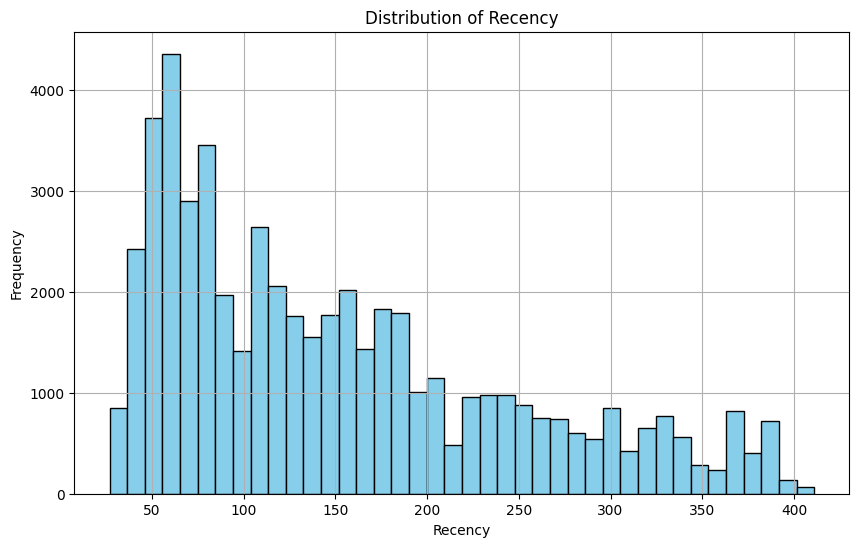

In [27]:
# Visualize the distribution of Recency for all customers.
plt.figure(figsize=(10, 6))
plt.hist(df['Recency'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribution of Recency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [28]:
print(df["Recency"].min())
print(df["Recency"].max())

27
411


The Recency of all customers ranges from 27 to 411, and it displays the distribution mentioned above.